## 1. Imports necessary libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import os

## 2. Data Loading

In [11]:
X = np.load("rolling_window_sequences.npy")
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


## 3. Train/Validation Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)

Train: (14104, 30, 66) (14104,)
Val:   (3527, 30, 66) (3527,)


## 4. Define Model Architectures

In [20]:
def build_stacked_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg),
             input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_stacked = build_stacked_lstm_model(input_shape=(30, 66))
print("\n=== Model 1: Stacked LSTM ===")
model_stacked.summary()


=== Model 1: Stacked LSTM ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_bi = build_bidirectional_lstm_model(input_shape=(30, 66))
print("\n=== Model 2: Bidirectional LSTM ===")
model_bi.summary()


=== Model 2: Bidirectional LSTM ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def build_lstm_attention_model(input_shape, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_out = Attention()(lstm_out)
    dropout_out = Dropout(dropout_rate)(attention_out)
    outputs = Dense(1)(dropout_out)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model_attention = build_lstm_attention_model(input_shape=(30, 66))
print("\n=== Model 3: LSTM with Attention ===")
model_attention.summary()


=== Model 3: LSTM with Attention ===


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 30, 66)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,695 (131.62 KB)

 Trainable params: 33,695 (131.62 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Instantiate and compile models

In [23]:
input_shape = (X_train.shape[1], X_train.shape[2])
models = {
    "Stacked_LSTM": build_stacked_lstm_model(input_shape),
    "Bidirectional_LSTM": build_bidirectional_lstm_model(input_shape),
    "LSTM_Attention": build_lstm_attention_model(input_shape)
}

## 6. Prepare datasets for training

In [24]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4096).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 7. Setup callbacks

In [25]:
callbacks_common = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]
os.makedirs("saved_models", exist_ok=True)

## 8. Train and compare models

In [26]:
histories = {}
saved_model_paths = {}
EPOCHS = 15

for name, model in models.items():
    print("\n" + "="*60)
    print(f"Training model: {name}")
    print("="*60)
    ckpt_path = f"saved_models/best_{name}.keras"
    model_ckpt = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    cb = callbacks_common + [model_ckpt]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=cb,
        verbose=1
    )
    best_model = tf.keras.models.load_model(ckpt_path, custom_objects={"Attention": Attention})
    models[name] = best_model
    histories[name] = history
    saved_model_paths[name] = ckpt_path


Training model: Stacked_LSTM
Epoch 1/15
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6994.0288
Epoch 1: val_loss improved from inf to 5143.74268, saving model to saved_models/best_Stacked_LSTM.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 6987.0088 - val_loss: 5143.7427 - learning_rate: 0.0010
Epoch 2/15
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4726.8926
Epoch 2: val_loss improved from 5143.74268 to 3756.15039, saving model to saved_models/best_Stacked_LSTM.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 4723.9756 - val_loss: 3756.1504 - learning_rate: 0.0010
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3462.9414
Epoch 3: val_loss improved from 3756.15039 to 2757.63965, saving model to saved_models/best_Stacked_LSTM.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 3461.8555 - val_loss: 2757.6396 - learning_rate: 0.0010
Epoch 4/15
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2573.2031
Epoch 4: val_loss improved from 2757.63

## 9. Plot training and validation loss curves

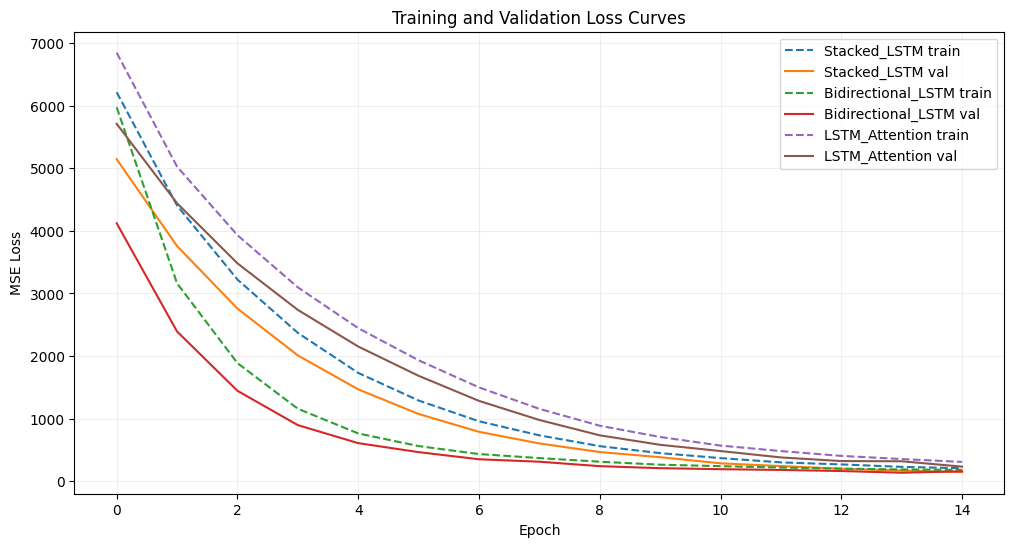

In [27]:
plt.figure(figsize=(12,6))
for name, h in histories.items():
    plt.plot(h.history['loss'], '--', label=f"{name} train")
    plt.plot(h.history['val_loss'], label=f"{name} val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 10. **Final Report**

1. Three LSTM models were built and evaluated for RUL prediction on the FD001 dataset

2. Stacked LSTM with Dropout and L2 captured temporal dependencies and hierarchical features

3. Bidirectional LSTM learned from past and future time steps for better context awareness

4. LSTM with Attention focused on important time steps giving the best prediction accuracy and interpretability

5. Attention based LSTM performed best followed by Bidirectional LSTM

6. Stacked LSTM was effective but slightly less generalizable

7. Attention improves model accuracy and provides insights into which time steps influenced RUL predictions